# Figure S3; Werner deconvolutions of ROSETTA-Ice lines  

#### Tankersley et al. 2022, Basement topography and sediment thickness beneath Antarctica's Ross Ice Shelf; GRL

#### Import packages and data

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy
import scipy.interpolate 
import pygmt
from matplotlib import gridspec
import matplotlib.image as mpimg

In [22]:
cd

C:\Users\matthewt


In [23]:
cd Documents\Python_Scripts\GRL_2021_Figures

C:\Users\matthewt\Documents\Python_Scripts\GRL_2021_Figures


#### Load OIB and ROSETTA data

In [24]:
rosetta_werner_all_points = pd.read_csv('ROSETTA_Werner_all_points.csv',header=0,index_col=None,sep=',')
rosetta_werner_binned_points = pd.read_csv('ROSETTA_Werner_binned_points.csv',header=0,index_col=None,sep=',')
oib_all_points = pd.read_csv('OIB_Werner_all_points.csv',header=0,index_col=None,sep=',')
oib_binned_points = pd.read_csv('OIB_Werner_binned_points.csv',header=0,index_col=None,sep=',')

In [25]:
rosetta_590_all_points=rosetta_werner_all_points[rosetta_werner_all_points.Line==590]
rosetta_590_binned_points=rosetta_werner_binned_points[rosetta_werner_binned_points.Line==590]

rosetta_650_all_points=rosetta_werner_all_points[rosetta_werner_all_points.Line==650]
rosetta_650_binned_points=rosetta_werner_binned_points[rosetta_werner_binned_points.Line==650]

oib_590_all_points=oib_all_points[oib_all_points.Line==404.590]
oib_590_binned_points=oib_binned_points[oib_binned_points.Line==404.590]

oib_650_all_points=oib_all_points[oib_all_points.Line==404.650]
oib_650_binned_points=oib_binned_points[oib_binned_points.Line==404.650]

In [26]:
x1 = min(rosetta_650_all_points.Distance)
x2 = max(rosetta_650_all_points.Distance) 
x_new_step = 5000
x_new = np.arange(x1, x2, x_new_step)  # creates array for distance to interpolate onto, 1 point every 10km
window = int(30_000/x_new_step)

f = scipy.interpolate.interp1d(rosetta_650_binned_points.Distance, rosetta_650_binned_points.Depth_sl_36k, kind='quadratic', fill_value='extrapolate') 
interp=f(x_new) 
interp_data={'Distance':x_new, 'interp':interp}
df_interp=pd.DataFrame(data=interp_data)
df_interp['filt'] = df_interp.interp.rolling(window, center=True).mean()
df_interp.sort_values(['Distance'], inplace=True)
df=rosetta_650_all_points.set_index('Distance').join(df_interp.set_index('Distance'), how='outer')
df.reset_index(inplace=True)
df.sort_values(['Distance'])

df.x.interpolate(method='linear', inplace=True)
df.y.interpolate(method='linear', inplace=True)

rosetta_650_all_points_just_line=df.drop(df.columns.difference(['x', 'y', 'filt', 'Distance']), 1)
rosetta_650_all_points_just_line.sort_values(['Distance'])
rosetta_650_all_points_just_line=rosetta_650_all_points_just_line[rosetta_650_all_points_just_line.filt.notna()]

oib_650_all_points_just_line=oib_650_all_points.drop(oib_650_all_points.columns.difference(['x', 'y', 'filt', 'Distance']), 1)
oib_650_all_points_just_line.sort_values(['Distance'])
oib_650_all_points_just_line=oib_650_all_points_just_line[oib_650_all_points_just_line.filt.notna()]

## Plot ROSETTA Line xsections

In [27]:
def plot_ROSETTA(Line, save_as_png=True):
    global fig
    fig = plt.figure()
    gs = gridspec.GridSpec(2,1, height_ratios=[3,1])
    ax0 = fig.add_subplot(gs[0])
    if Line==590:
        #### BEDMAP2 BED
        ax0.plot(rosetta_590_all_points.x, rosetta_590_all_points.bedmap2_bed, 
                 c='mediumturquoise', linewidth=1.5, 
                 label='Bathymetry')
        #### FILTERED DIKES
        # ROSETTA
        ax0.scatter(rosetta_590_all_points.x, rosetta_590_all_points.Depth_sl_filtered, 
                    s = rosetta_590_all_points.Susc*2, marker='o', 
                    edgecolors='k', facecolors='none', linewidth=.6, 
                    label='Scaled ROSETTA solutions')
        ax0.scatter(rosetta_590_all_points.x, rosetta_590_all_points.Depth_Dikes, 
                    s = 1.5, marker='.', edgecolor='none', 
                    facecolor='k', 
                    label='All ROSETTA solutions')
        ############################################
        ############################################    
        #### SOLUTIONS
        # ROSETTA
        ax0.scatter(rosetta_590_binned_points.x, rosetta_590_binned_points.Depth_sl_36k, 
                    marker='X', c='darkorange', s=80, zorder=20, edgecolors='k', linewidth=.5,
                    label='ROSETTA solutions')
        #Use if comparing RS points to OIB line
        # OIB LINE
        ax0.plot(oib_590_all_points.x[oib_590_all_points.filt.notna()], 
                 oib_590_all_points.filt[oib_590_all_points.filt.notna()], 
                 c='b', linewidth=3, label='OIB basement')
        # ROSETTA LINE
        x1 = min(rosetta_590_all_points.Distance)
        x2 = max(rosetta_590_all_points.Distance) 
        window = int(30000/5000)
        x_new = np.arange(x1, x2, 5000)  # creates array for distance to interpolate onto, 1 point every 5km
        f = scipy.interpolate.interp1d(rosetta_590_binned_points.Distance, rosetta_590_binned_points.Depth_sl_36k, kind='quadratic', fill_value='extrapolate') 
        interp=f(x_new)  
        interp_data={'Distance':x_new, 'interp':interp}
        df_interp=pd.DataFrame(data=interp_data)
        df_interp['filt'] = df_interp.interp.rolling(window, center=True).mean()
        df_interp.sort_values(['Distance'], inplace=True)
        df5=rosetta_590_all_points.set_index('Distance').join(df_interp.set_index('Distance'), how='outer')
        df5.reset_index(inplace=True)
        df5.sort_values(['Distance'])
        df5.x.interpolate(method='linear', inplace=True)
        df5.y.interpolate(method='linear', inplace=True)
        df5.bedmap2_bed.interpolate(method='linear', inplace=True)   
        ax0.plot(df5.x[df5.filt.notna()], 
                 df5.filt[df5.filt.notna()], 
                 c='darkorange', linewidth=2, label='ROSETTA basement')
        error=480
        ax0.fill_between(df5.x[df5.filt.notna()], 
                         df5.filt[df5.filt.notna()]-error, 
                         df5.filt[df5.filt.notna()]+error,
                         facecolor='darkorange', alpha=.3)
        ############################################
        ############################################ 
        #### ROSETTA MAG    
        ax1 = fig.add_subplot(gs[1], sharex=ax0)
        ax1.scatter(rosetta_590_all_points.x, rosetta_590_all_points.Mag_anom_draped_1000, 
                    s=.05, c='magenta', label='ROSETTA')
        #### OIB MAG
        ax3 = fig.add_subplot(gs[1],  sharex=ax0)
        ax3.patch.set_alpha(0)
        ax3.scatter(oib_590_all_points.x, oib_590_all_points.Mag_anom_draped_1000, 
                    s=.05, c='k', label='OIB')
        ax3.yaxis.tick_left()
        ax1.yaxis.tick_left()###############################
        ax3.tick_params(axis='both', labelsize=8)
        ax3.set_ylabel('Magnetic anomaly (nT)', size=8, labelpad=10)
        #### SET TICKS / LIMITS         
        ax1.set_xlim(rosetta_590_all_points.x.min(), rosetta_590_all_points.x.max()) 
        ax1.set_xticks(np.arange(round(rosetta_590_all_points.x.min(), -5), 
                                 round(rosetta_590_all_points.x.max(), -5), 100000))
        ax1.set_xticklabels(np.arange(int(round(rosetta_590_all_points.x.min()/1000, -2)), 
                                      int(round(rosetta_590_all_points.x.max()/1000, -2)), 100))
        ax1.set_xticks(np.arange(round(rosetta_590_all_points.x.min(), -5), 
                                 round(rosetta_590_all_points.x.max(), 5), 20000), minor=True)
        ax1.tick_params(axis='both', labelsize=8)
        ax1.tick_params(axis='y', labelsize=8, colors='magenta', pad=0)##############################
        ax0.tick_params(axis='both', labelsize=8)
        ax0.set_ylim(-8000, 0)
        ax0.set_yticks((-6000, -4000, -2000, 0))
        ax0.set_yticklabels((-6, -4, -2, 0))
        ax0.set_axisbelow(True)
        ax0.grid(axis='x', which='major', alpha=0.8)
        ax0.grid(axis='x', which='minor', alpha=0.3)
        ax1.set_axisbelow(True)
        ax1.grid(axis='x', which='major', alpha=0.8)
        ax1.grid(axis='x', which='minor', alpha=0.3)
        ax0.set_ylabel('Depth (km)', size=8)
        ax1.set_xlabel('Easting (km)')
        lgnd = ax0.legend(loc='lower right', fontsize=6, markerscale=4,framealpha=1)
        lgnd3 = ax0.legend(loc='lower left', fontsize=6, markerscale=4, framealpha=1)
        lgnd.remove()
        ax0.add_artist(lgnd)
        lgnd.legendHandles[-4]._sizes = [20]
        lgnd.legendHandles[-3]._sizes = [20]
        lgnd.legendHandles[-2]._sizes = [20]
        lgnd.legendHandles[-1]._sizes = [20]
        ax1.annotate(text='OIB', xy=(0.01,0.8), xycoords='axes fraction', fontsize=6)
        ax1.annotate(text='ROSETTA', xy=(0.01,0.9), xycoords='axes fraction', fontsize=6, color='magenta')
        
        ax0.text(x=-100000, y=-400, s='Mid-Shelf High', fontsize=8)
        ax0.text(x=150000, y=-400, s='Western Ross Basin', fontsize=8)
        
        ax0.set_title('OIB 404 / ROSETTA 590 ')
        fig.subplots_adjust(hspace=0)
        plt.setp(ax0.get_xticklabels(),visible=False)
        
    elif Line==650:
        #### BEDMAP2 BED
        ax0.plot(rosetta_650_all_points.x, rosetta_650_all_points.bedmap2_bed, 
                 c='mediumturquoise', linewidth=1.5, 
                 label='Bathymetry')
        #### FILTERED DIKES
        # ROSETTA
        ax0.scatter(rosetta_650_all_points.x, rosetta_650_all_points.Depth_sl_filtered, 
                    s = rosetta_650_all_points.Susc*2, marker='o', 
                    edgecolors='k', facecolors='none', linewidth=.6, 
                    label='Scaled ROSETTA solutions')
        ax0.scatter(rosetta_650_all_points.x, rosetta_650_all_points.Depth_Dikes, 
                    s = 1.5, marker='.', edgecolor='none', 
                    facecolor='k', 
                    label='All ROSETTA solutions')
        ############################################
        ############################################    
        #### SOLUTIONS
        # ROSETTA
        ax0.scatter(rosetta_650_binned_points.x, rosetta_650_binned_points.Depth_sl_36k, 
                    marker='X', c='darkorange', s=80, zorder=20, edgecolors='k', linewidth=.5,
                    label='ROSETTA solutions')
        #Use if comparing RS points to OIB line
        # OIB LINE
        ax0.plot(oib_650_all_points.x[oib_650_all_points.filt.notna()], 
                 oib_650_all_points.filt[oib_650_all_points.filt.notna()], 
                 c='b', linewidth=3, label='OIB basement')
        # ROSETTA LINE
        x1 = min(rosetta_650_all_points.Distance)
        x2 = max(rosetta_650_all_points.Distance) 
        window = int(30000/5000)
        x_new = np.arange(x1, x2, 5000)  # creates array for distance to interpolate onto, 1 point every 5km
        f = scipy.interpolate.interp1d(rosetta_650_binned_points.Distance, rosetta_650_binned_points.Depth_sl_36k, kind='quadratic', fill_value='extrapolate') 
        interp=f(x_new)  
        interp_data={'Distance':x_new, 'interp':interp}
        df_interp=pd.DataFrame(data=interp_data)
        df_interp['filt'] = df_interp.interp.rolling(window, center=True).mean()
        df_interp.sort_values(['Distance'], inplace=True)
        df5=rosetta_650_all_points.set_index('Distance').join(df_interp.set_index('Distance'), how='outer')
        df5.reset_index(inplace=True)
        df5.sort_values(['Distance'])
        df5.x.interpolate(method='linear', inplace=True)
        ax0.plot(df5.x[df5.filt.notna()], 
                 df5.filt[df5.filt.notna()], 
                 c='darkorange', linewidth=2, label='ROSETTA basement')
        error=480
        ax0.fill_between(df5.x[df5.filt.notna()], 
                         df5.filt[df5.filt.notna()]-error, 
                         df5.filt[df5.filt.notna()]+error,
                         facecolor='darkorange', alpha=.3)
        ############################################
        ############################################ 
        #### ROSETTA MAG    
        ax1b = fig.add_subplot(gs[1], sharex=ax0)
        ax1b.scatter(rosetta_650_all_points.x, rosetta_650_all_points.Mag_anom_draped_1000, 
                    s=.05, c='magenta', label='ROSETTA')
        #### OIB MAG
        ax3b = fig.add_subplot(gs[1],  sharex=ax0)
        ax3b.patch.set_alpha(0)
        ax3b.scatter(oib_650_all_points.x, oib_650_all_points.Mag_anom_draped_1000, 
                    s=.05, c='k', label='OIB')
        ax3b.yaxis.tick_left()
        ax1b.yaxis.tick_left()
        ax3b.tick_params(axis='both', labelsize=8)
        ax3b.set_ylabel('Magnetic anomaly (nT)', size=8, labelpad=10)
        #### SET TICKS / LIMITS         
        ax1b.set_xlim(rosetta_650_all_points.x.min(), rosetta_650_all_points.x.max()) 
        ax1b.set_xticks(np.arange(round(rosetta_650_all_points.x.min(), -5), 
                                 round(rosetta_650_all_points.x.max(), -5), 100000))
        ax1b.set_xticklabels(np.arange(int(round(rosetta_650_all_points.x.min()/1000, -2)), 
                                      int(round(rosetta_650_all_points.x.max()/1000, -2)), 100))
        ax1b.set_xticks(np.arange(round(rosetta_650_all_points.x.min(), -5), 
                                 round(rosetta_650_all_points.x.max(), 5), 20000), minor=True)
        ax1b.set_yticks(ticks=(-900,-1100))
    
        ax1b.tick_params(axis='both', labelsize=8)
        ax1b.tick_params(axis='y', labelsize=8, colors='magenta', pad=0)
        ax0.tick_params(axis='both', labelsize=8)
        ax0.set_ylim(-8000, 0)
        ax0.set_yticks((-6000, -4000, -2000, 0))
        ax0.set_yticklabels((-6, -4, -2, 0))
        ax0.set_axisbelow(True)
        ax0.grid(axis='x', which='major', alpha=0.8)
        ax0.grid(axis='x', which='minor', alpha=0.3)
        ax1b.set_axisbelow(True)
        ax1b.grid(axis='x', which='major', alpha=0.8)
        ax1b.grid(axis='x', which='minor', alpha=0.3)
        ax0.set_ylabel('Depth (km)', size=8)
        ax1b.set_xlabel('Easting (km)')
        lgnd = ax0.legend(loc='lower right', fontsize=6, markerscale=4,framealpha=1)
        lgnd3 = ax0.legend(loc='lower left', fontsize=6, markerscale=4, framealpha=1)
        lgnd.remove()
        ax0.add_artist(lgnd)
        lgnd.legendHandles[-4]._sizes = [20]
        lgnd.legendHandles[-3]._sizes = [20]
        lgnd.legendHandles[-2]._sizes = [20]
        lgnd.legendHandles[-1]._sizes = [20]
        ax1b.annotate(text='OIB', xy=(0.01,0.8), xycoords='axes fraction', fontsize=6)
        ax1b.annotate(text='ROSETTA', xy=(0.01,0.9), xycoords='axes fraction', fontsize=6, color='magenta')
        
        ax0.text(x=-350000, y=-400, s='Roosevelt Island', fontsize=8)
        ax0.text(x=-120000, y=-400, s='Mid-Shelf High', fontsize=8)
        ax0.text(x=100000, y=-400, s='Western Ross Basin', fontsize=8)
        
        ax0.set_title('OIB 404 / ROSETTA 650')
        fig.subplots_adjust(hspace=0)
        plt.setp(ax0.get_xticklabels(),visible=False)
    else:
        Line=Line
        all_points=rosetta_werner_all_points[rosetta_werner_all_points.Line==Line]
        binned_points=rosetta_werner_binned_points[rosetta_werner_binned_points.Line==Line]

        #fit line to binned points
        x1 = min(binned_points.Distance)
        x2 = max(binned_points.Distance) 
        x_new_step = 5000
        window = int(30000/x_new_step)
        x_new = np.arange(x1, x2, x_new_step)  # creates array for distance to interpolate onto, 1 point every 5km
        f = scipy.interpolate.interp1d(binned_points.Distance, binned_points.Depth_sl_36k, kind='quadratic', fill_value='extrapolate') 
        interp=f(x_new)  
        interp_data={'Distance':x_new, 'interp':interp}
        df_interp=pd.DataFrame(data=interp_data)
        df_interp['filt'] = df_interp.interp.rolling(window, center=True).mean()
        df_interp.sort_values(['Distance'], inplace=True)
        df_interp

        window_cutoff=26_000
        susc_cutoff=1.2
        bin_size =36_000 
        count_min=40

        #### vertical lines of bin size
        ax0.vlines(all_points.Distance_36k.unique(),ymin=-10000, ymax=0, color='k', linewidth=1).set_alpha(.2)        
        #### BEDMAP2 BED
        ax0.plot(all_points.Distance, all_points.bedmap2_bed,  c='mediumturquoise', linewidth=1.5, label='Bathymetry')
        #### ROSETTA FILTERED DIKES 
        solutions_d = all_points[(all_points.Window_Width < window_cutoff) & (all_points.Susc > susc_cutoff)]                          
        #scaled by Susc
        ax0.scatter(solutions_d.Distance, solutions_d.Depth_Dikes, s = solutions_d.Susc*2, marker='o', edgecolors='k', facecolors='none', linewidth=.5, label='Scaled solutions')
        ax0.scatter(all_points.Distance, all_points.Depth_Dikes, s = 1, marker='.', edgecolor='none', facecolor='k', label='All solutions')
        #### ROSETTA SMOOTHED LINE
        ax0.plot(df_interp.Distance[df_interp.filt.notna()], 
                 df_interp.filt[df_interp.filt.notna()], 
                 c='darkorange', 
                 label='Magnetic basement')
        error=480
        ax0.fill_between(df_interp.Distance[df_interp.filt.notna()], 
                         df_interp.filt[df_interp.filt.notna()]-error, 
                         df_interp.filt[df_interp.filt.notna()]+error,
                         facecolor='darkorange', alpha=.3)
        #### ROSETTA BINNED POINTS
        ax0.scatter(binned_points.Distance, binned_points.Depth_sl_36k, marker='x', c='darkorange', s=60, label='Binned points', zorder=5) 
        #### ROSETTA MAG    
        ax1 = fig.add_subplot(gs[1], sharex=ax0)
        ax1.scatter(all_points.Distance, all_points.Mag_anom_draped_1000, s=.05, c='r')

        #### ROSETTA Basement grid sampled
        all_points = all_points[ ['y'] + [ col for col in all_points.columns if col != 'y' ] ]
        all_points = all_points[ ['x'] + [ col for col in all_points.columns if col != 'x' ] ]
        all_points=pygmt.grdtrack(points=all_points, grid='../GRL_2021_Figures/rosetta_lindeque_basement_g80kfilt.nc', 
                                  newcolname='../GRL_2021_Figures/rosetta_lindeque_basement_g80kfilt.nc')
        ax0.plot(all_points.Distance[all_points['../GRL_2021_Figures/rosetta_lindeque_basement_g80kfilt.nc'].notna()], 
                 all_points['../GRL_2021_Figures/rosetta_lindeque_basement_g80kfilt.nc'][all_points['../GRL_2021_Figures/rosetta_lindeque_basement_g80kfilt.nc'].notna()], 
                 c='b', label='Gridded Mag basement')

        # reverse x axis if flight is West to East
        if all_points.Distance[all_points.x.idxmin()] > all_points.Distance[all_points.x.idxmax()]:
            ax1.set_xlim(all_points.Distance.max(), all_points.Distance.min()) 
            ax1.set_xticks(np.arange(all_points.Distance.min(), all_points.Distance.max(), 100000))
            ax1.set_xticklabels(np.arange(0, int((all_points.Distance.max())/1000), 100))
            ax1.set_xticks(np.arange(0, int((all_points.Distance.max())), 20000), minor=True)
        else:
            ax1.set_xlim(all_points.Distance.min(), all_points.Distance.max())
            ax1.set_xticks(np.arange(all_points.Distance.min(), all_points.Distance.max(), 100000))
            ax1.set_xticklabels(np.arange(0, int((all_points.Distance.max())/1000), 100))
            ax1.set_xticks(np.arange(0, int((all_points.Distance.max())), 20000), minor=True)

        ax1.tick_params(axis='both', labelsize=8)
        ax0.tick_params(axis='both', labelsize=8)

        ax0.set_ylim(-8000, 0)
        ax0.set_yticks((-6000, -4000, -2000, 0))
        ax0.set_yticklabels((-6, -4, -2, 0))
        
        if Line==270:
            ax0.text(x=400000, y=-400, s='Crary Trough', fontsize=8)
            ax0.text(x=280000, y=-400, s='Mid-Shelf High', fontsize=8)
            ax0.text(x=150000, y=-400, s='Western Ross Basin', fontsize=8)
        if Line==310:
            ax0.text(x=400000, y=-400, s='Crary Trough', fontsize=8)
            ax0.text(x=300000, y=-400, s='Mid-Shelf High', fontsize=8)
            ax0.text(x=170000, y=-400, s='Western Ross Basin', fontsize=8)
        if Line==410:
            ax0.text(x=60000, y=-400, s='Siple Dome Basin', fontsize=8)
            ax0.text(x=300000, y=-400, s='Mid-Shelf High', fontsize=8)
            ax0.text(x=500000, y=-400, s='Western Ross Basin', fontsize=8)
        if Line==430:
            ax0.text(x=720000, y=-400, s='Siple Dome Basin', fontsize=8)
            ax0.text(x=470000, y=-400, s='Mid-Shelf High', fontsize=8)
            ax0.text(x=220000, y=-400, s='Western Ross Basin', fontsize=8)

        ax1.grid(axis='x', which='major', alpha=0.8)
        ax1.grid(axis='x', which='minor', alpha=0.3)
        ax0.set_ylabel('Depth (km)', size=8)
        ax1.set_ylabel('Magnetic anomaly (nT)', size=8)
        ax1.set_xlabel('Distance (km)')
        lgnd = ax0.legend(loc='lower right', fontsize=6, markerscale=4,framealpha=1)
        lgnd.legendHandles[-3]._sizes = [20]
        lgnd.legendHandles[-2]._sizes = [20]
        lgnd.legendHandles[-1]._sizes = [20]
        ax0.set_title('ROSETTA Line '+str(Line))
        fig.subplots_adjust(hspace=0)
        plt.setp(ax0.get_xticklabels(),visible=False)
    if save_as_png==True:
        out=f"images\ROSETTA_line_{str(Line)}.png"
        fig.savefig(out, dpi=500)
    plt.close()

## Plot ROSETTA Lines individually 

In [28]:
# plot_ROSETTA(Line=270) #270,310,410,430,590,650

## Plot ROSETTA Lines as subplots 

In [29]:
def plot_figs_as_subplots(lines, save_as_png=False):
    for x in lines:
        plot_ROSETTA(Line=x)
    plt.figure(figsize=(20,20))
    images=[]
    string1 = 'images/ROSETTA_line_'
    string2 = '.png'
    fig_list = [string1 + str(x) + string2 for x in lines]
    for f in fig_list:
        images.append(mpimg.imread(f))
    for i, image in enumerate(images):
        if len(fig_list)>1:
            rows=int(np.ceil(len(fig_list)/2))
            cols=int(np.ceil(len(fig_list)/rows))
            plt.subplot(rows, cols, i + 1)
            label=['a','b','c','d','e','f']
            plt.text(200,200, label[i], fontsize='40') # add labels to each subplot
        else:
            plt.subplot(1, 1, i + 1)
        plt.axis("off")
        plt.imshow(image, aspect='equal')

    plt.subplots_adjust(hspace=0, wspace=0)
    plt.tight_layout(pad=0, w_pad=-7, h_pad=-4)
    if save_as_png==True:
        plt.savefig("..\..\Manuscripts\GRL_Mag_Basement_2020\FigS3_RIS_transects.jpg", dpi=200)
    plt.show()
    plt.close()
    
plt.show()

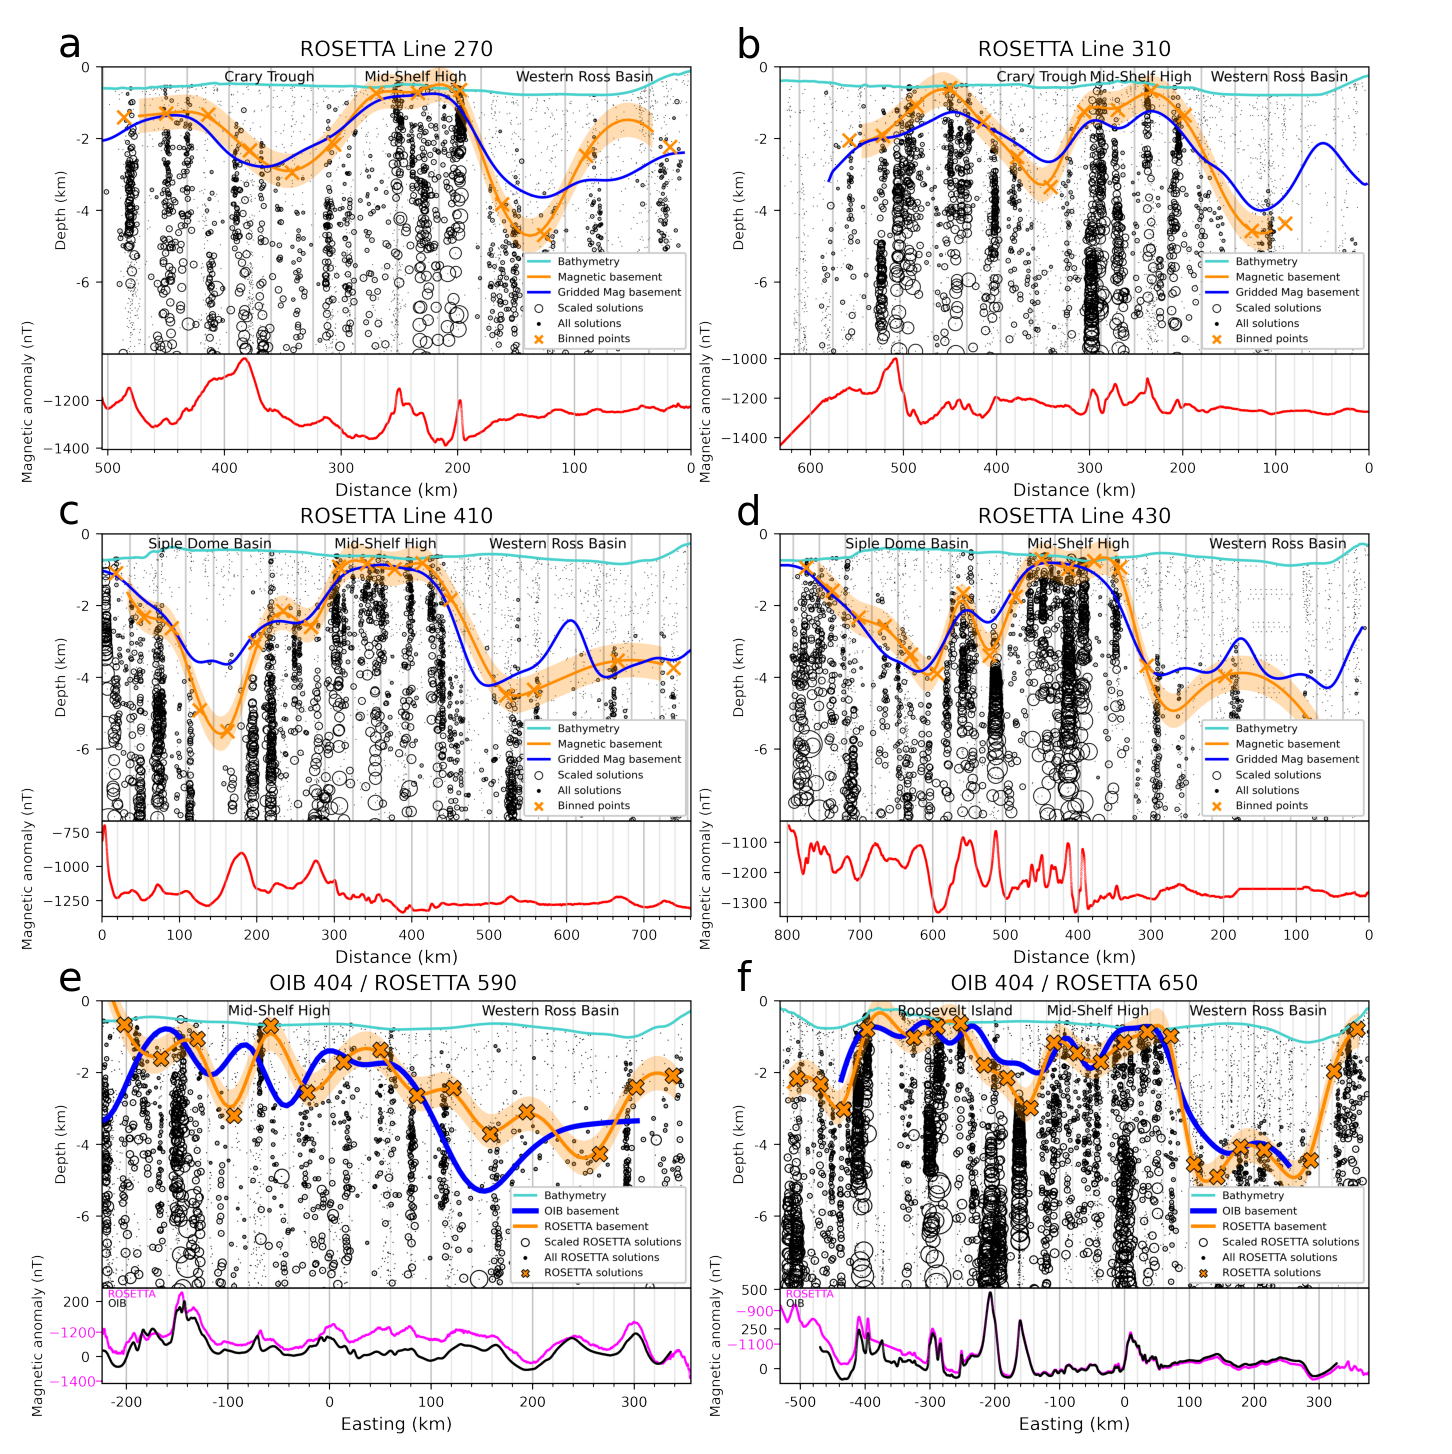

In [30]:
plot_figs_as_subplots(lines=(270,310,410,430,590,650), save_as_png=True)